In [1]:
import spot
spot.setup()

In [2]:
seminator_path = '../seminator'
def seminator(filename, opt = ''):
    a = spot.automaton(f'{seminator_path} {opt} -s0 {filename} |')
    display(a)
    return a

def seminator_form(formula, opt = ''):
    a = spot.automaton(f'ltl2tgba \'{formula}\' | {seminator_path} {opt} -s0 |')
    display(a)
    return a

def highlight(f):
    a = spot.translate(f)
    spot.highlight_nondet_states(a,1)
    display(a.show('.s'))

The orange states below form deterministic bottom SCCs. After processing by Seminator, they are both in the 1st(violet) and 2nd (green) component. Simplifications cannot merge these duplicates as onw is accepting and one is not. In fact, we do not need the copy in the first component as there is no non-determinism and so there is nothing to wait for. We have to make every edge entering such SCC as a cut-edge.

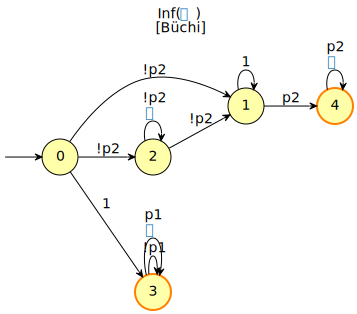

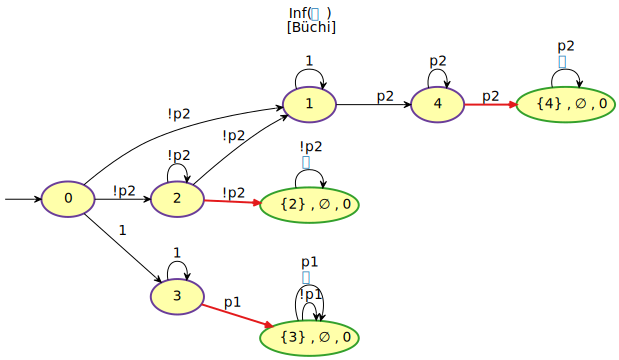

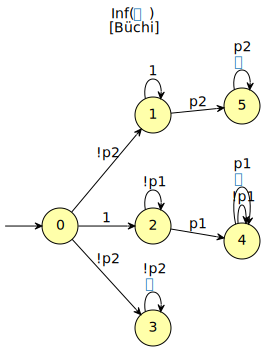

In [3]:
f = "(FGp2 R !p2) | GFp1"
in_a = spot.translate(f)
display(in_a.highlight_states([3,4],2))
seminator_form(f, '--highlight').postprocess()

## Cut-deterministic automata
The same idea can be applied to cut-deterministic automata. Removing the states 3 and 4 from the fist part of the cut-deterministic automaton would remove state $\{3\}$ and would merge the states $\{1,3,4\}$ and $\{1,3\}$.

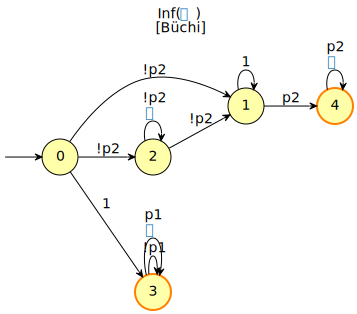

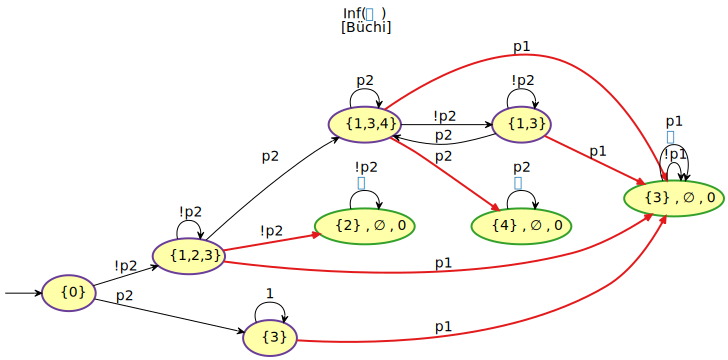

In [4]:
display(in_a)
seminator_form(f, '--highlight --cd');

## Test implementation

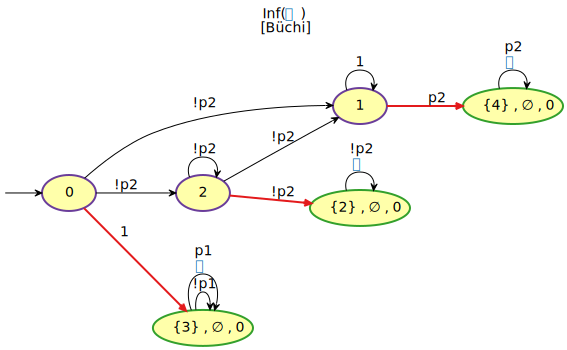

In [5]:
spot.automaton(f"ltl2tgba -f '{f}' | ~/tools/seminator/seminator --highlight --bscc-avoid -s0|")

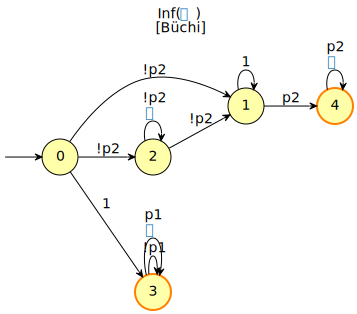

In [6]:
in_a

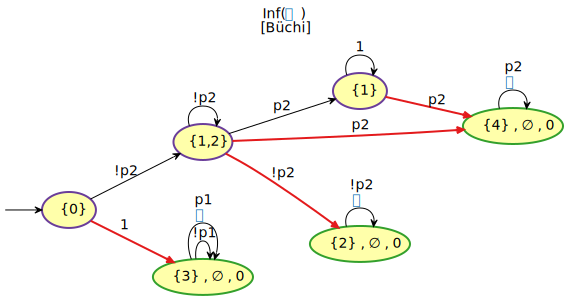

In [7]:
spot.automaton(f"ltl2tgba -f '{f}' | ~/tools/seminator/seminator --highlight --bscc-avoid --cd -s0|")

### Prepare test

In [8]:
option = 'bscc-avoid'
print(in_a.to_str(), file=open(f"{option}.hoa",'w'))
res = !{seminator_path} -s0 --{option} {option}.hoa
res_cd = !{seminator_path} -s0 --{option} --cd {option}.hoa
result = "\n".join(res)
result_cd = "\n".join(res_cd)
testfile = f"../tests/{option}.test"
test = f'''#!/bin/bash
set -e

cat >{option}.hoa <<EOF
{in_a.to_str()}
EOF

cat >{option}.expect <<EOF
{result}
EOF

cat >{option}.cd.expect <<EOF
{result_cd}
EOF


../seminator -s0 --{option} {option}.hoa > {option}.out
../seminator -s0 --{option} --cd {option}.hoa > {option}.cd.out
cat {option}.out
cat {option}.cd.out
diff {option}.out {option}.expect
diff {option}.cd.out {option}.cd.expect

rm {option}.hoa {option}.out {option}.expect {option}.cd.out {option}.cd.expect
'''

In [9]:
print(test,file=open(testfile,'w'))
!chmod +x {testfile}

In [10]:
!{testfile}

HOA: v1
States: 6
Start: 0
AP: 2 "p2" "p1"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels trans-acc semi-deterministic
--BODY--
State: 0 "0"
[!0] 1
[!0] 2
[t] 3
State: 1 "1"
[t] 1
[0] 4
State: 2 "2"
[!0] 1
[!0] 2
[!0] 5
State: 3 "{3} , ∅ , 0"
[!1] 3
[1] 3 {0}
State: 4 "{4} , ∅ , 0"
[0] 4 {0}
State: 5 "{2} , ∅ , 0"
[!0] 5 {0}
--END--
HOA: v1
States: 6
Start: 0
AP: 2 "p2" "p1"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels trans-acc semi-deterministic
--BODY--
State: 0 "{0}"
[!0] 1
[t] 3
State: 1 "{1,2}"
[!0] 1
[0] 2
[0] 4
[!0] 5
State: 2 "{1}"
[t] 2
[0] 4
State: 3 "{3} , ∅ , 0"
[!1] 3
[1] 3 {0}
State: 4 "{4} , ∅ , 0"
[0] 4 {0}
State: 5 "{2} , ∅ , 0"
[!0] 5 {0}
--END--


## Exension to _semi-deterministic_ SCCs
We can avoid more than bottom SCC. In fact, we can avoid all SCCs that are already good for semi-deterministic automaton (_semi-deterministic SCC_). SCC $C$ is semi-deterministic if $C$ and all successors of $C$ are deterministic. This is ilustrated on the following example and stats 1 and 5.

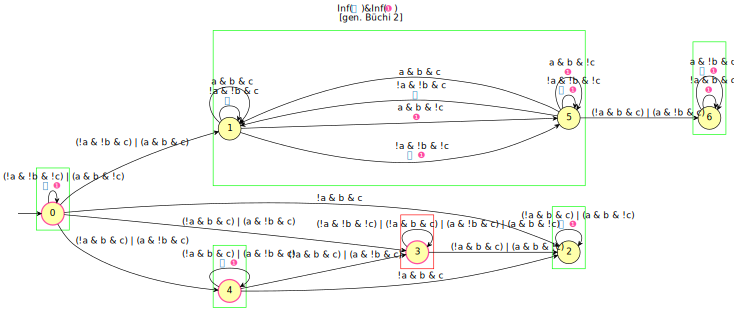

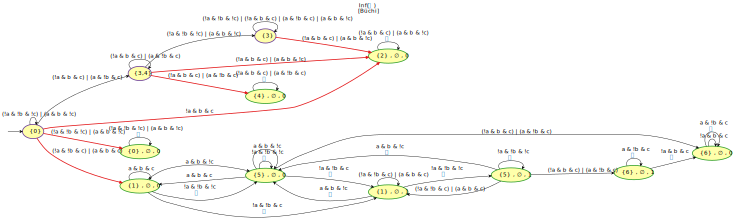

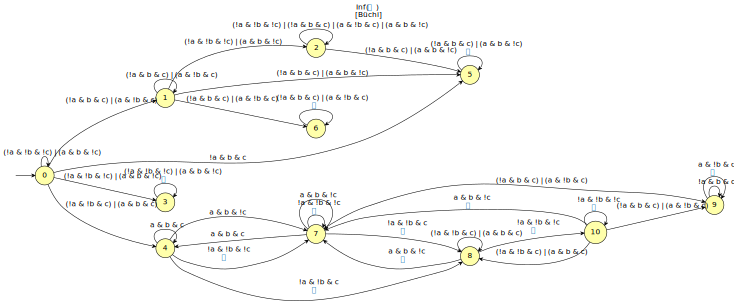

In [11]:
f = 'G((((a & b) | (!a & !b)) & (GF!b U !c)) | (((!a & b) | (a & !b)) & (FGb R c)))'
highlight(f)
seminator_form(f,"--cd --highlight --via-tgba --skip-levels --bscc-avoid").postprocess().postprocess()

## Reusing the semi-deterministic components with TGBA acceptance
In the previous example we have saved several states by not including the semi-deterministic components in the 1st part of the result. However, we still got 6 (and 5 after postprocessing) states out of the 3 deterministic states $1, 5$, and $6$. This can be tackled by reusing the semi-deterministic components as they are. This immediately leads to an TGBA on the output and we have to adress this in the parts which still rely on breakpoint construction. The edges that are accepting will now carry all the marks that are needed (as they do in the original automaton anyway). 

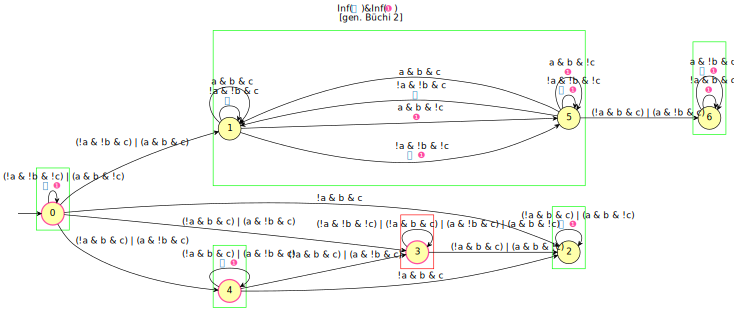

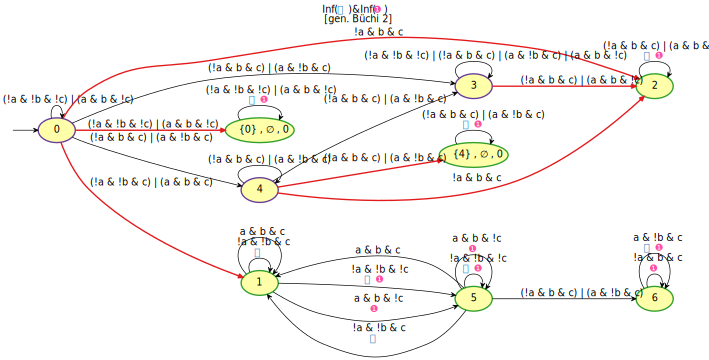

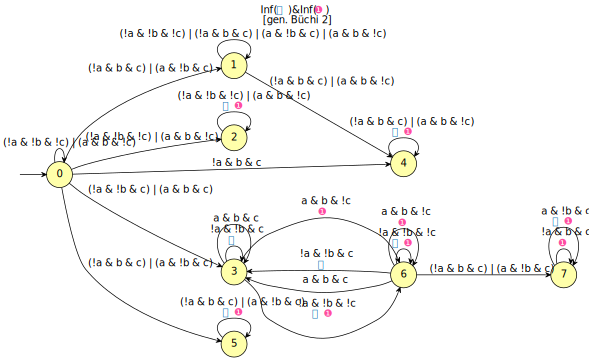

In [12]:
f = 'G((((a & b) | (!a & !b)) & (GF!b U !c)) | (((!a & b) | (a & !b)) & (FGb R c)))'
highlight(f)
seminator_form(f,"--highlight --via-tgba --skip-levels --powerset-on-cut --reuse-good-SCC").postprocess().postprocess()

### Prepare test

In [13]:
option = 'reuse-good-SCC'
in_a = spot.translate(f)
print(in_a.to_str(), file=open(f"{option}.hoa",'w'))
res = !{seminator_path} -s0 --{option} {option}.hoa
res_cd = !{seminator_path} -s0 --{option} --cd {option}.hoa
result = "\n".join(res)
result_cd = "\n".join(res_cd)
testfile = f"../tests/{option}.test"
test = f'''#!/bin/bash
set -e

cat >{option}.hoa <<EOF
{in_a.to_str()}
EOF

cat >{option}.expect <<EOF
{result}
EOF

cat >{option}.cd.expect <<EOF
{result_cd}
EOF


../seminator -s0 --{option} {option}.hoa > {option}.out
../seminator -s0 --{option} --cd {option}.hoa > {option}.cd.out
cat {option}.out
cat {option}.cd.out
diff {option}.out {option}.expect
diff {option}.cd.out {option}.cd.expect

rm {option}.hoa {option}.out {option}.expect {option}.cd.out {option}.cd.expect
'''

In [14]:
print(test,file=open(testfile,'w'))
!chmod +x {testfile}

In [15]:
!{testfile}

HOA: v1
States: 11
Start: 0
AP: 3 "a" "b" "c"
acc-name: generalized-Buchi 2
Acceptance: 2 Inf(0)&Inf(1)
properties: trans-labels explicit-labels trans-acc semi-deterministic
--BODY--
State: 0 "0"
[!0&!1&!2 | 0&1&!2] 0
[!0&1&2 | 0&!1&2] 1
[!0&1&2 | 0&!1&2] 2
[!0&!1&!2 | 0&1&!2] 3
[!0&!1&2 | 0&1&2] 4
[!0&1&2] 5
State: 1 "3"
[!0&!1&!2 | !0&1&2 | 0&!1&2 | 0&1&!2] 1
[!0&1&2 | 0&1&!2] 5
State: 2 "4"
[!0&1&2 | 0&!1&2] 1
[!0&1&2 | 0&!1&2] 2
[!0&1&2] 5
[!0&1&2 | 0&!1&2] 6
State: 3 "{0} , ∅ , 0"
[!0&!1&!2 | 0&1&!2] 7 {0 1}
State: 4 "1"
[!0&!1&2] 4 {0}
[0&1&2] 4
[!0&!1&!2] 8 {0 1}
[0&1&!2] 8 {1}
State: 5 "2"
[!0&1&2 | 0&1&!2] 5 {0 1}
State: 6 "{4} , ∅ , 0"
[!0&1&2 | 0&!1&2] 9 {0 1}
State: 7 "{0} , ∅ , 1"
[!0&!1&!2 | 0&1&!2] 3 {0 1}
State: 8 "5"
[!0&!1&2] 4 {0}
[0&1&2] 4
[!0&!1&!2] 8 {0 1}
[0&1&!2] 8 {1}
[!0&1&2 | 0&!1&2] 10
State: 9 "{4} , ∅ , 1"
[!0&1&2 | 0&!1&2] 6 {0 1}
State: 10 "6"
[!0&1&2] 10 {1}
[0&!1&2] 10 {0 1}
--END--
HOA: v1
States: 11
Start: 0
AP: 3 "a" "b" "c"
acc-name: generalized-Bu